In [8]:
#Standard data analytical libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import os, warnings, time, dmba
import scikitplot as skplt #pip install scikit-plot

#Data Mining Book Libraries
from dmba import liftChart, gainsChart,regressionSummary, classificationSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection, adjusted_r2_score, AIC_score, BIC_score
from os.path import exists
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,accuracy_score, roc_curve, auc,roc_auc_score,plot_confusion_matrix,confusion_matrix,r2_score
#Classification 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression,  LinearRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Used to save keystrokes when wanting to print something. Now we can just use
# p("Hello") instead of print("Hello")
p = print
# import csv
# import re
computer = 'o_desktop'
#computer = 'other'
if (computer == 'o_desktop'):
    os.environ['NUMEXPR_MAX_THREADS'] = '24'
else:
    #default is 4 or 8
    os.environ['NUMEXPR_MAX_THREADS'] = '8'

# For future use.
# import threading
# import multiprocessing

### Data Preparation (Wrangling and Pre-Processing)<a class="anchor" id="preprocess"></a>

To prepare the data for modeling, a number of preprocessing steps were taken. 
First...

In [9]:
repo_directory = r"C:/ADS_599_Final/"
data_folder_directory = r"C:/ADS_599_Final/Data_Folder/"
df_features_file = "C:/ADS_599_Final/Data_Folder/training_set_features.csv"
df_labels_file = "C:/ADS_599_Final/Data_Folder/training_set_labels.csv"
df = pd.read_csv(df_features_file)
df_labels = pd.read_csv(df_labels_file)

#This is a very important step.
#We are combining our feature and target/label variables.
df.join(df_labels.set_index('respondent_id'), on='respondent_id')

df.head(5)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


Show unique values per column in preparation of data cleaning and transformation.
Only needs to be done once since the files saved in the repo.

In [10]:
uniq_values_file = "unique_values_in_column.txt"
uniq_counts_file = 'unique_counts_in_column.txt'
if not exists(data_folder_directory + uniq_values_file):
    for col in df:
        #Unique values in each column
        with open(uniq_values_file, 'a') as f:
            f.write(str(df[col].unique()))
            f.write('\n')
        p(df[col].unique())

if not exists(data_folder_directory+ uniq_counts_file):
    for col in df:
        #Occurance of each unique row value
        #must set dropna=False
        with open(uniq_counts_file, 'a') as f:
            f.write( str(df[col].value_counts(dropna=False) ))
            f.write('\n')
        p(df[col].value_counts())


We show the number of null values per column below.

In [11]:
p("The null counts per column are: ")
p(df.isnull().sum())
p("Health insurance stands out at missing nearly 50%")

p("\nThe shape of the dataframe is: ")
p(df.shape)

The null counts per column are: 
respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
incom

Handling the Nulls

In [13]:

# respondent_id are all unique so its irrelevant now that we merged.
clean_df = df.drop(columns=["respondent_id"],inplace=False)
# About 50 percent of health_insurance is missing.
# TODO We should try models with that drop the health_insurance column.
#clean_df = df.drop(columns=["health_insurance", "respondent_id"],inplace=False)


encoding_selection = "label" # options "label" "onehot"
if encoding_selection == "label":
    df_train = clean_df
    # Encode labels the below is equivalent to df_train['hhs_geo_region']= label_encoder.fit_transform(df_train['hhs_geo_region'])
    df_train["hhs_geo_region"] = df_train["hhs_geo_region"].astype('category')
    df_train["hhs_geo_region"] = df_train["hhs_geo_region"].cat.codes
    df_train["census_msa"] = df_train["census_msa"].astype('category')
    df_train["census_msa"] = df_train["census_msa"].cat.codes
    df_train["employment_industry"] = df_train["employment_industry"].astype('category')
    df_train["employment_industry"] = df_train["employment_industry"].cat.codes
    df_train["employment_occupation"] = df_train["employment_occupation"].astype('category')
    df_train["employment_occupation"] = df_train["employment_occupation"].cat.codes
    df_train["employment_status"] = df_train["employment_status"].astype('category')
    df_train["employment_status"] = df_train["employment_status"].cat.codes
    df_train["rent_or_own"] = df_train["rent_or_own"].astype('category')
    df_train["rent_or_own"] = df_train["rent_or_own"].cat.codes
    df_train["marital_status"] = df_train["marital_status"].astype('category')
    df_train["marital_status"] = df_train["marital_status"].cat.codes
    df_train["income_poverty"] = df_train["income_poverty"].astype('category')
    df_train["income_poverty"] = df_train["income_poverty"].cat.codes
    df_train["race"] = df_train["race"].astype('category')
    df_train["race"] = df_train["race"].cat.codes
    df_train["education"] = df_train["education"].astype('category')
    df_train["education"] = df_train["education"].cat.codes
    df_train["age_group"] = df_train["age_group"].astype('category')
    df_train["age_group"] = df_train["age_group"].cat.codes
    df_train["sex"] = df_train["sex"].astype('category')
    df_train["sex"] = df_train["sex"].cat.codes
elif encoding_selection == "onehot":
    # Right now are are using label encoding. 
    # TODO We could try other encoding methods and see if the results improve
    p("We can try one hot encoder here.")

handling_nulls = "iterative" # options "averages" "iterative" "dropall" "noresponse"
if handling_nulls == "iterative":
    # SMOTE Sampling
    imp = IterativeImputer(max_iter=10, random_state=0)
    imp.fit(clean_df)
    df_train = pd.DataFrame(data=imp.transform(clean_df))
    df_train.columns = clean_df.columns
    df_train
elif handling_nulls == "averages":
    df_train = clean_df
    # Technically we shouldn't use mean when there is a skew, i.e. with salaries
    df_train.fillna(clean_df.mean())
    # TODO We use median or mode if the column data is skewed
    #newdf_train.fillna(clean_df.median())
    #newdf_train.fillna(clean_df.mode())
elif handling_nulls == "dropall":
    # See how it is if we drop the NaNs
    clean_df = clean_df.dropna(inplace=False) #This should be replace with imputation.
else: #elif handling_nulls == "noresponse":
    p("We are replacing NaN with no_response for categories and -1 for numbers.")
    df_train = clean_df
    df_train['h1n1_concern'] = df_train['h1n1_concern'].fillna(-1)
    df_train['h1n1_knowledge'] = df_train['h1n1_knowledge'].fillna(-1)
    df_train['behavioral_antiviral_meds'] = df_train['behavioral_antiviral_meds'].fillna(-1)
    df_train['behavioral_avoidance'] = df_train['behavioral_avoidance'].fillna(-1)
    df_train['behavioral_face_mask, '] = df_train['behavioral_face_mask, '].fillna(-1)
    df_train['behavioral_large_gatherings, '] = df_train['behavioral_large_gatherings, '].fillna(-1)
    df_train['behavioral_outside_home, '] = df_train['behavioral_outside_home, '].fillna(-1)
    df_train['behavioral_touch_face'] = df_train['behavioral_touch_face'].fillna(-1)
    df_train['doctor_recc_h1n1'] = df_train['doctor_recc_h1n1'].fillna(-1)
    df_train['doctor_recc_seasonal'] = df_train['doctor_recc_seasonal'].fillna(-1)
    df_train['chronic_med_condition'] = df_train['chronic_med_condition'].fillna(-1)
    df_train['child_under_6_months'] = df_train['child_under_6_months'].fillna(-1)
    df_train['health_worker'] = df_train['health_worker'].fillna(-1)
    df_train['health_insurance'] = df_train['health_insurance'].fillna(-1)
    df_train['opinion_h1n1_vacc_effective'] = df_train['opinion_h1n1_vacc_effective'].fillna(-1)
    df_train['opinion_h1n1_sick_from_vacc'] = df_train['opinion_h1n1_sick_from_vacc'].fillna(-1)
    df_train['opinion_h1n1_risk'] = df_train['opinion_h1n1_risk'].fillna(-1)
    df_train['opinion_seas_vacc_effective'] = df_train['opinion_seas_vacc_effective'].fillna(-1)
    df_train['opinion_seas_risk'] = df_train['opinion_seas_risk'].fillna(-1)
    df_train['opinion_seas_sick_from_vacc'] = df_train['opinion_seas_sick_from_vacc'].fillna(-1)
    df_train['household_adults'] = df_train['household_adults'].fillna(-1)
    df_train['household_children'] = df_train['household_children'].fillna(-1)
    # placeholder 
    df_train['opinion_h1n1_risk'] = df_train['opinion_h1n1_risk'].fillna(-1)

    df_train['age_group'] = df_train['age_group'].fillna("no_response")
    df_train['education'] = df_train['education'].fillna("no_response")
    df_train['race'] = df_train['race'].fillna("no_response")
    df_train['income_poverty'] = df_train['income_poverty'].fillna("no_response")
    df_train['marital_status'] = df_train['marital_status'].fillna("no_response")
    df_train['rent_or_own'] = df_train['rent_or_own'].fillna("no_response")
    df_train['employment_status'] = df_train['employment_status'].fillna("no_response")
    df_train['employment_occupation'] = df_train['employment_occupation'].fillna("no_response")
    df_train['employment_industry'] = df_train['employment_industry'].fillna("no_response")
    #This would replace all NaNs with the same value. We don't this.
    #df.fillna("no_response")




#Scale the values (removes means and scale to unit variance)
scalar = MinMaxScaler()
df_train['PWD_UPDT_TS'] = scalar.fit_transform(df_train['PWD_UPDT_TS'].values.reshape(-1,1))

ValueError: could not convert string to float: 'Female'

Gotta convert those categories to numbers. Category encoding known in the R world as as.factor-ing. 

NameError: name 'IterativeImputer' is not defined

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In order to better understand the variables, both numeric and categorical, the plots below were produced. Bars for the frequency of a category or numeric range are shown, along with a density curve. An interesting note is the bimodality ..... and columnX demonstrates a right-skewed distribution.

A correlation heatmap of the numeric variables is also visualized.  ...strong relationship besides.... The correlation between all variables was then calculated along with the variance of each variable.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

ValueError: could not convert string to float: '35 - 44 Years'

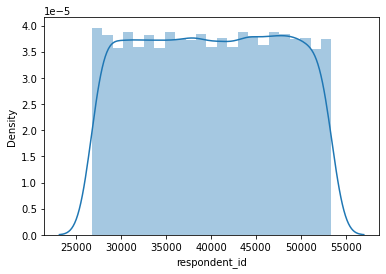

<Figure size 432x288 with 0 Axes>

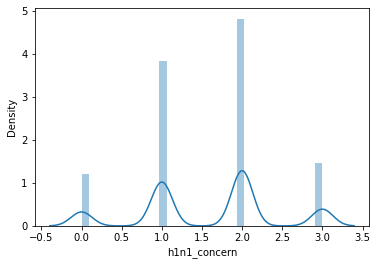

<Figure size 432x288 with 0 Axes>

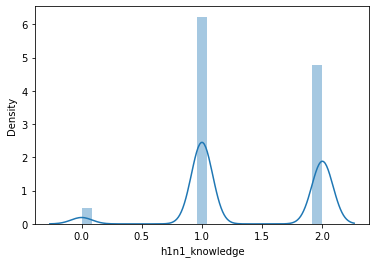

<Figure size 432x288 with 0 Axes>

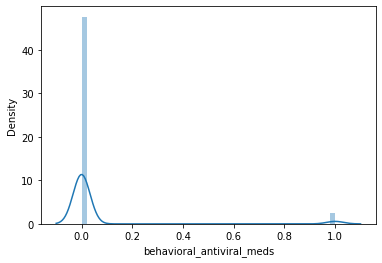

<Figure size 432x288 with 0 Axes>

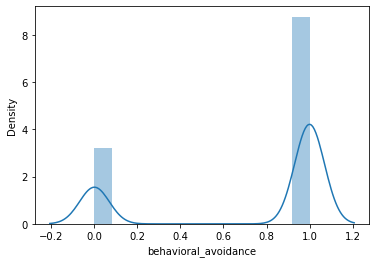

<Figure size 432x288 with 0 Axes>

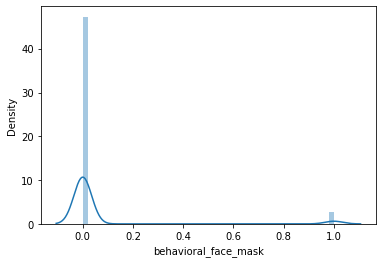

<Figure size 432x288 with 0 Axes>

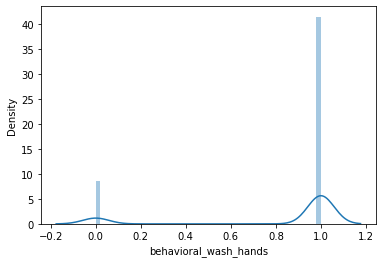

<Figure size 432x288 with 0 Axes>

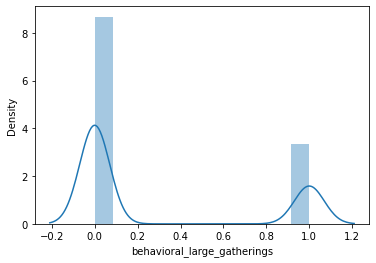

<Figure size 432x288 with 0 Axes>

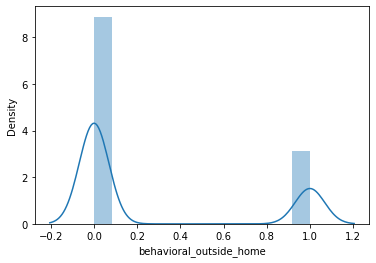

<Figure size 432x288 with 0 Axes>

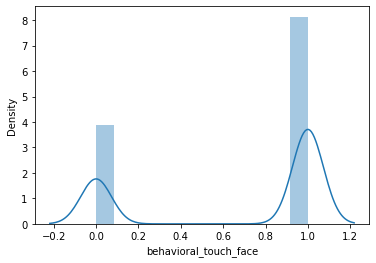

<Figure size 432x288 with 0 Axes>

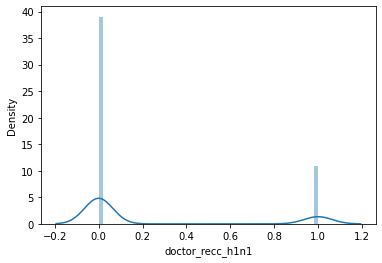

<Figure size 432x288 with 0 Axes>

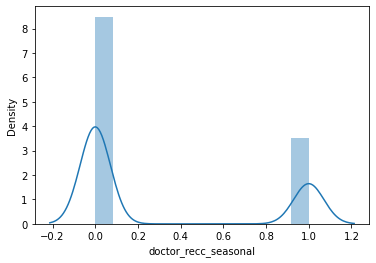

<Figure size 432x288 with 0 Axes>

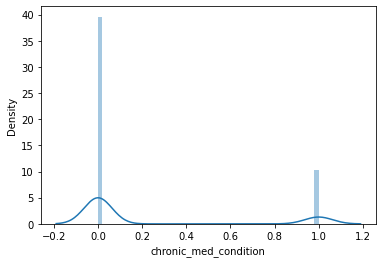

<Figure size 432x288 with 0 Axes>

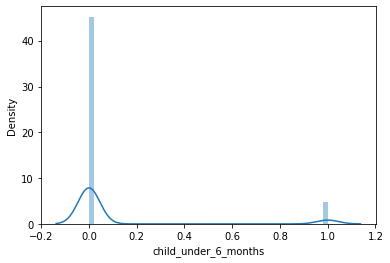

<Figure size 432x288 with 0 Axes>

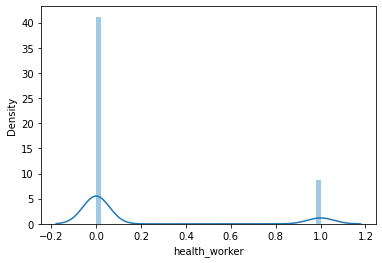

<Figure size 432x288 with 0 Axes>

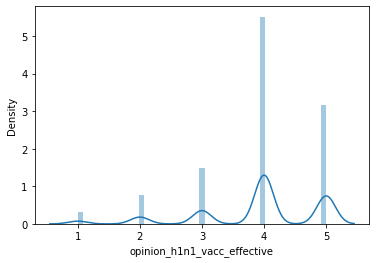

<Figure size 432x288 with 0 Axes>

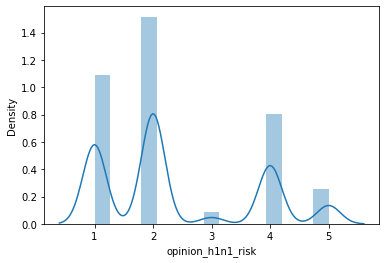

<Figure size 432x288 with 0 Axes>

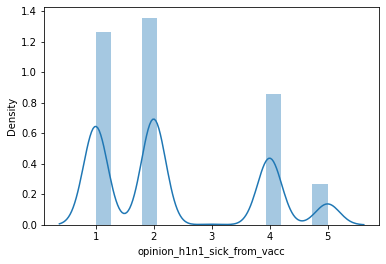

<Figure size 432x288 with 0 Axes>

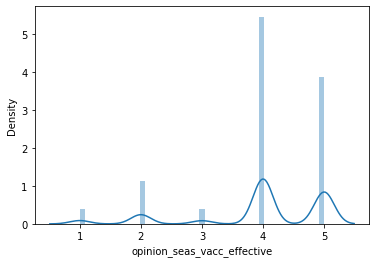

<Figure size 432x288 with 0 Axes>

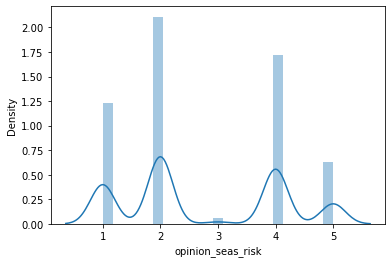

<Figure size 432x288 with 0 Axes>

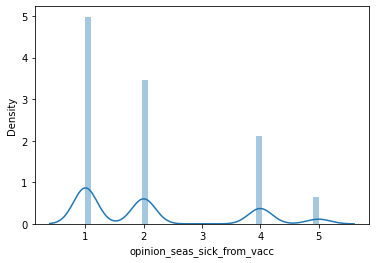

<Figure size 432x288 with 0 Axes>

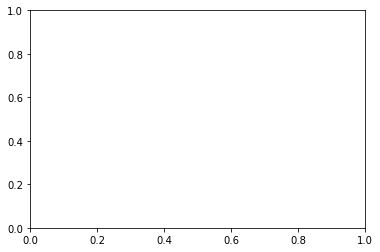

In [23]:

# create distplots
for column in clean_df.columns:
    plt.figure()            
    sns.distplot(clean_df[column])
    plt.figure()